Michael Fouts  
CHE 625  
March 6, 2023  
Midterm

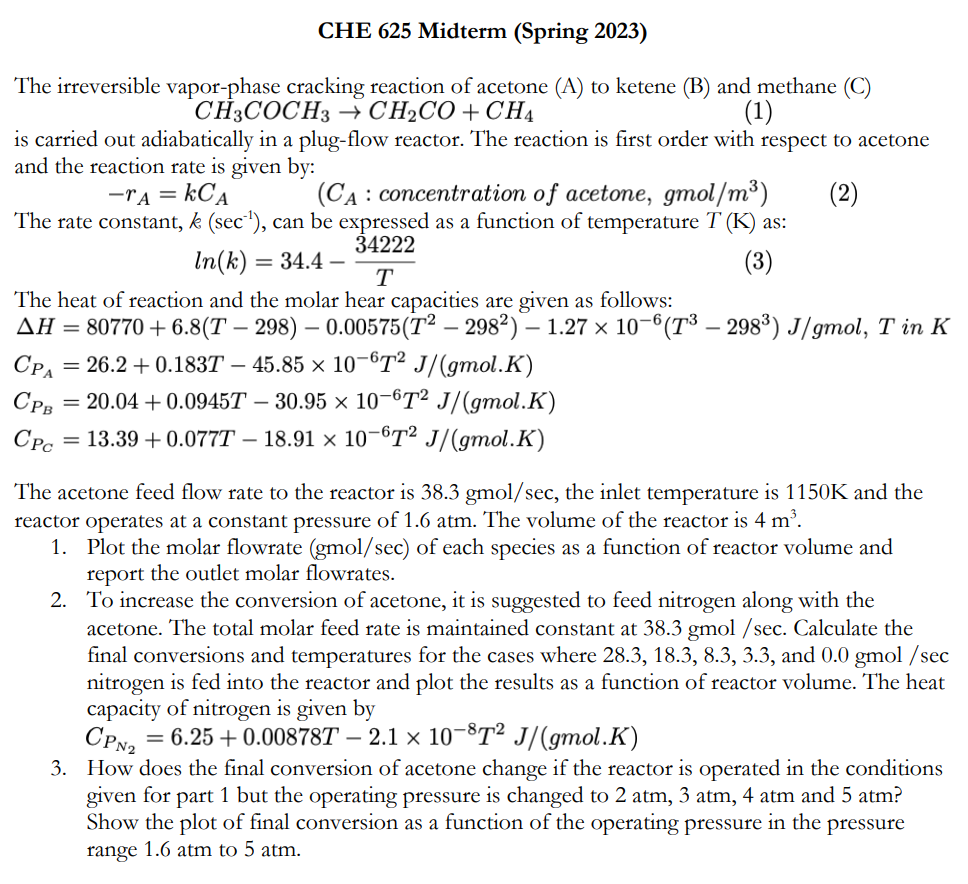

# Question 1

Plot the molar flowrate (gmol/sec) of each species as a function of reactor volume and report the outlet molar flowrates.

To start this problem, we first need to model the reactor as a set of differential equations.  The derivations of the equations are done by hand below.

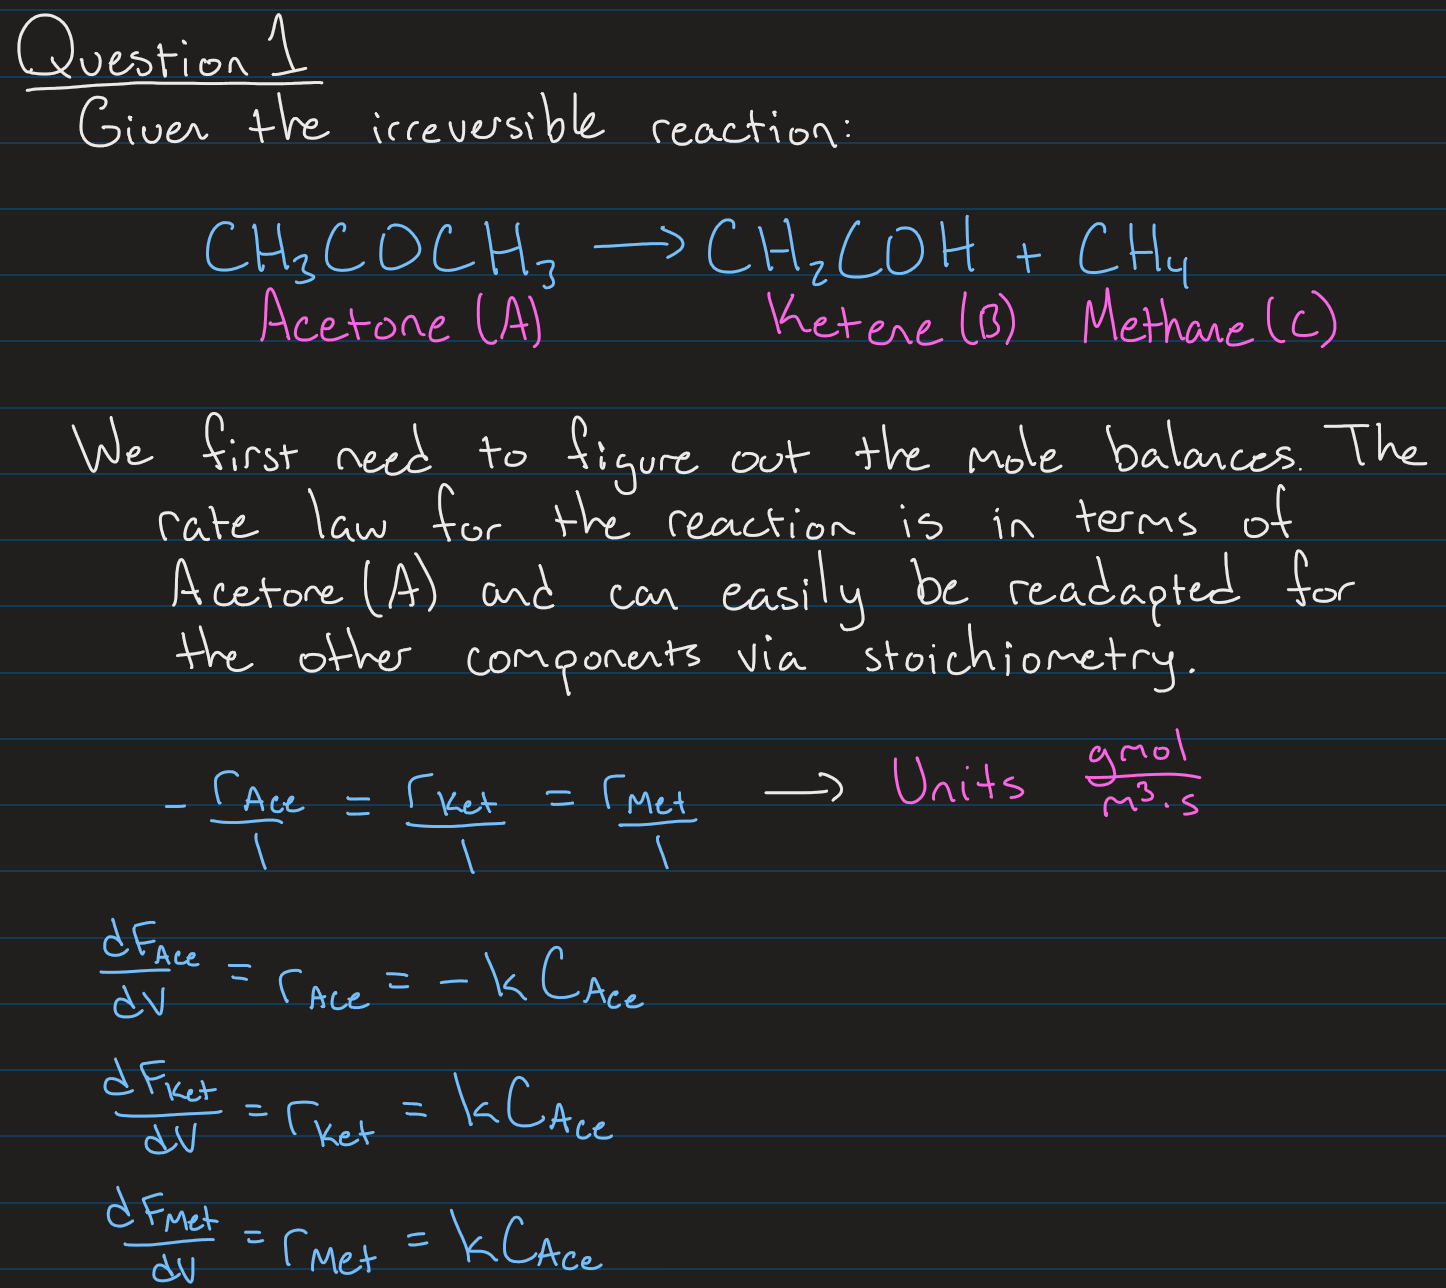

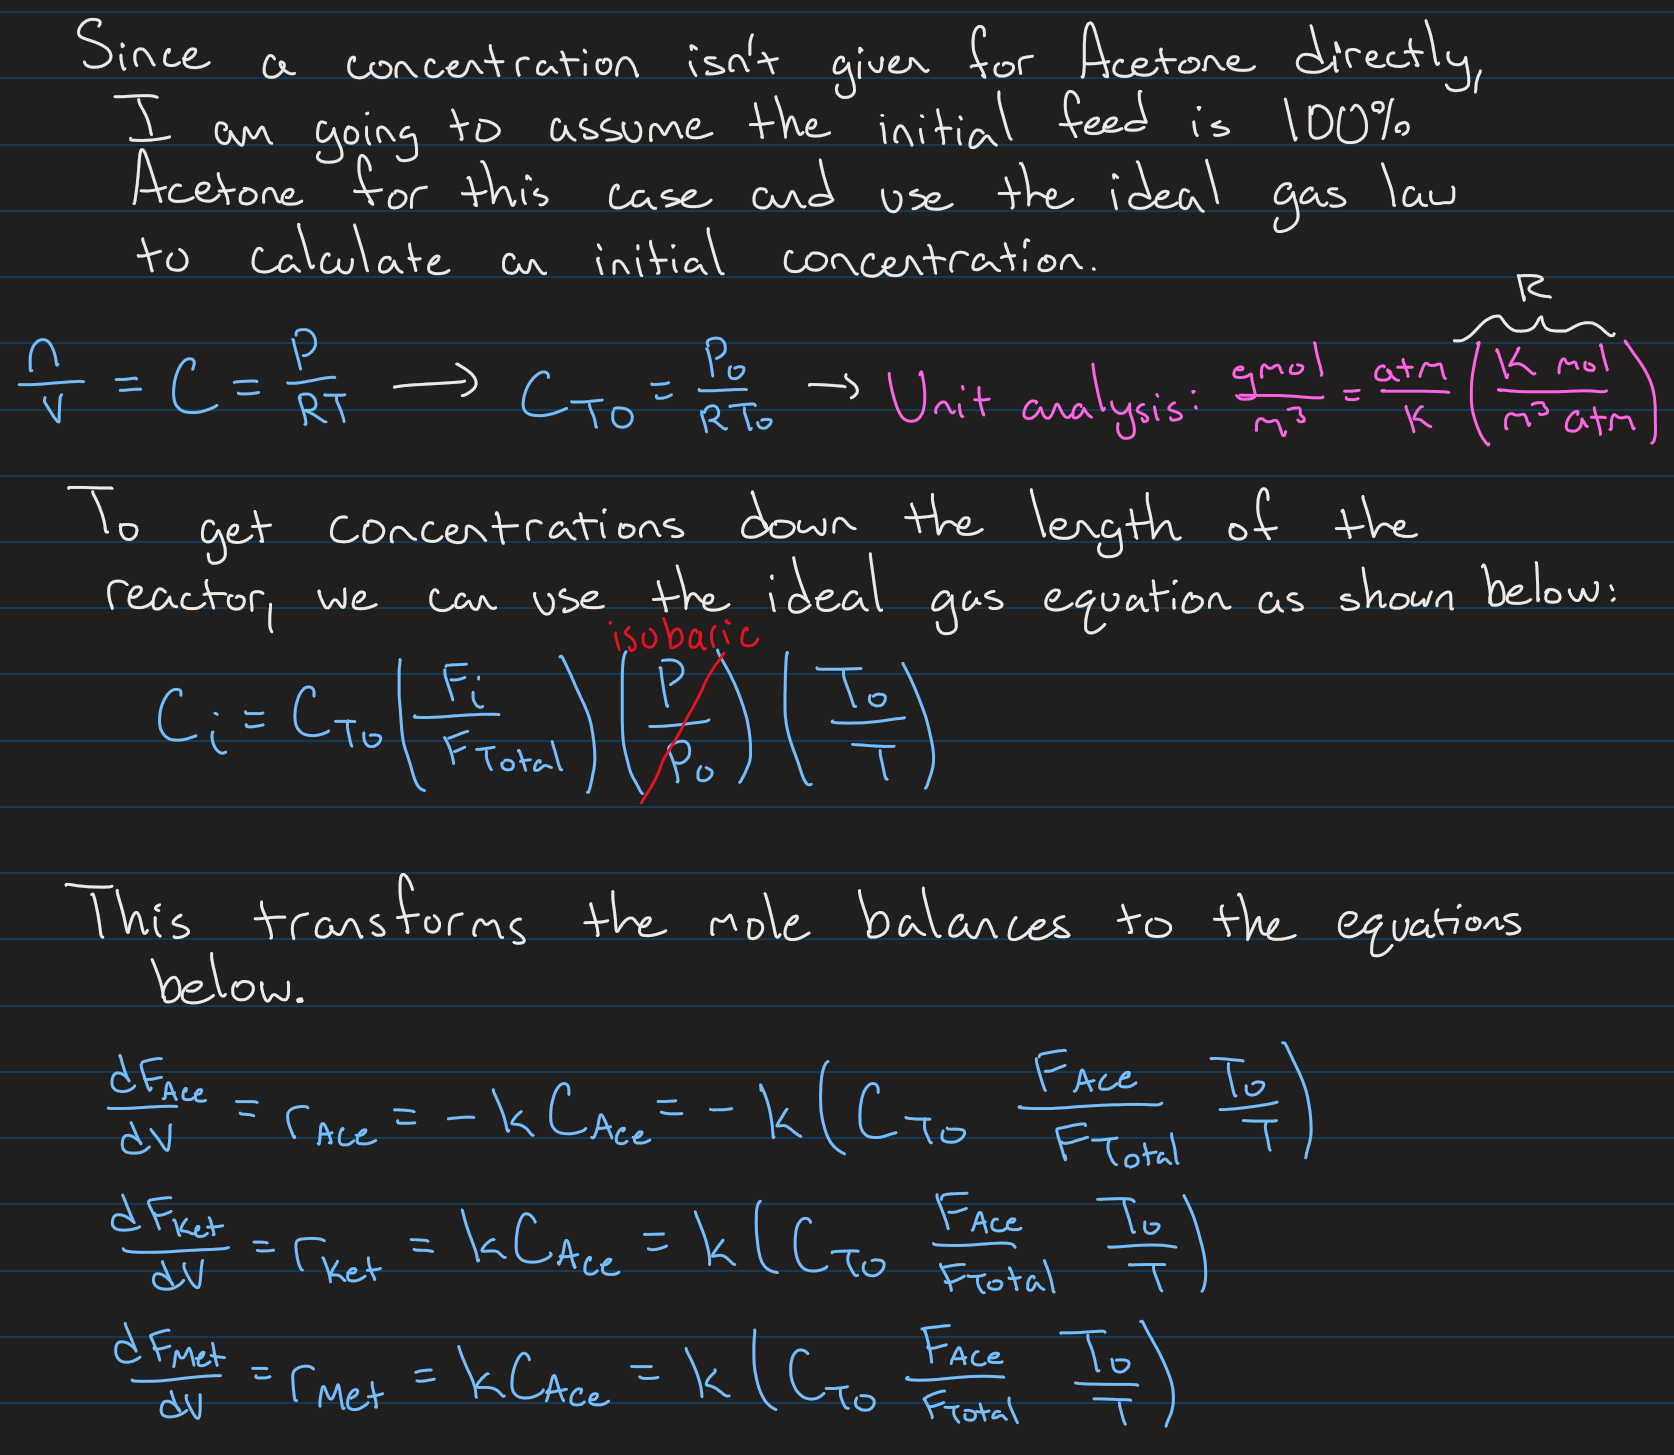

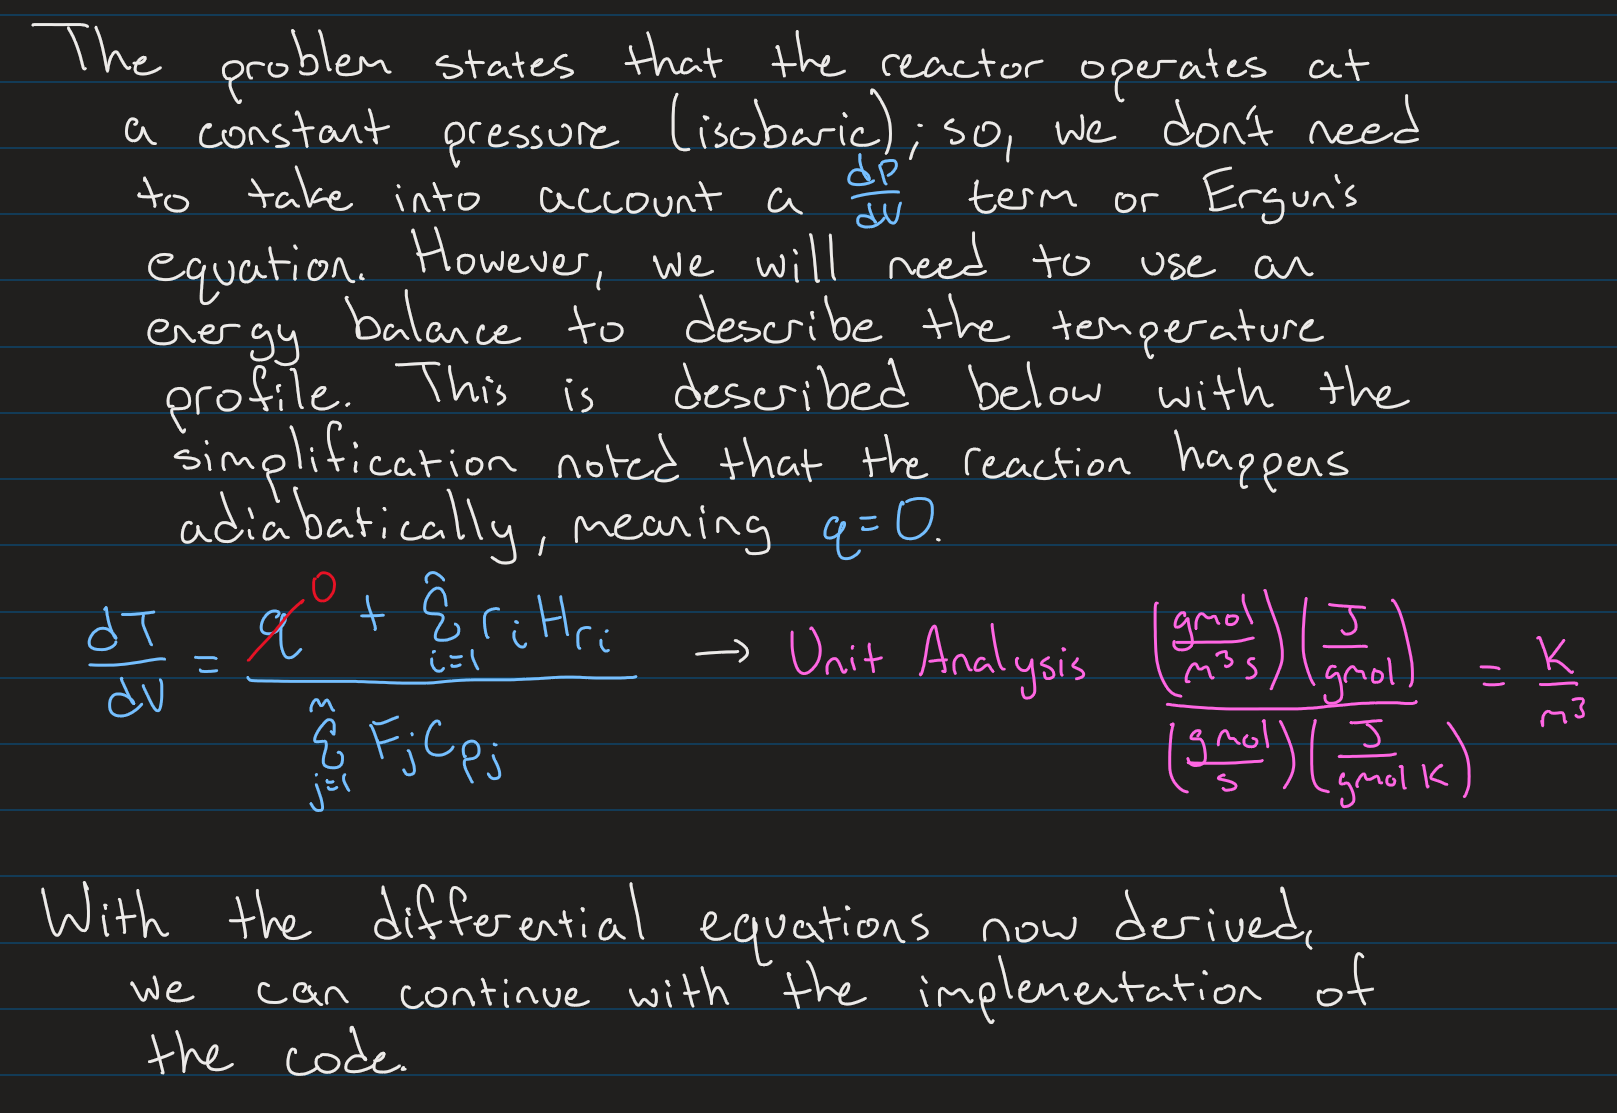

In [1]:
# Import relevant libraries

# For data processing
import math
import pandas as pd
import numpy as np

# For integration
from scipy.integrate import solve_ivp

# For visualizations
import seaborn as sns
import matplotlib
sns.set_theme()
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(font_scale=1.25)

The cell below models the reactor in the form of a function where v is the differential volume of the reactor (independent variable) and the input called *variables* is a list of the dependent variables in relation to volume.  The cell below shows the code implementation of the differential equations derived above.

In [2]:
def dV(v,variables):
    '''
    This function takes in a volume as an independent variable and
    a list called variables as the dependent variables and returns the
    incremental changes of the functions simulating the changing
    elements down the length of the reactor.
    '''
    # Define Variables for readability
    Face = variables[0] # gmol/s
    Fket = variables[1] # gmol/s
    Fmet = variables[2] # gmol/s
    T = variables[3] # K

    # Define constants here
    P = 1.6 # atm
    T0 = 1150 # K
    R = 8.20573660809596 * 10**-5 # (m3 atm)/(K mol)

    # Create aggrgate variables
    Ft = (Face + Fket + Fmet) #gmol/sec
    Ct0 = P/R/T0 # gmol/m3
    Cace = Ct0*(Face/Ft)*(T0/T) # gmol/m3

    # Define other variables
    k = math.exp(34.4 - (34222/T)) # 1/sec
    del_H = 80770 + 6.8*(T - 298) - 0.00575*(T**2 - 298**2) - (1.27*10**-6)*(T**3 - 298**3) # J/gmol
    Cpace = 26.2 + 0.183*T - (45.85*10**-6)*T**2 # J/(gmol K)
    Cpket = 20.04 + 0.0945*T - (30.95*10**-6)*T**2 # J/(gmol K)
    Cpmet = 13.39 + 0.077*T - (18.91*10**-6)*T**2 # J/(gmol K)

    # Change Equations
    dFace = -k*Cace # gmol/ (s m3)
    dFket = k*Cace # gmol/ (s m3)
    dFmet = k*Cace # gmol/ (s m3)
    dT = (dFace*del_H)/(Face*Cpace + Fket*Cpket + Fmet*Cpmet) # K / m3

    return [dFace, dFket, dFmet, dT]

The next cells shows the actual integration of the set of differential equations above, the transformation of the outputs, and finally a graph of the concentrations along the length of the reactor.

In [3]:
# min and max volume for integration
volume_span = [0, 4]
# specify each volume point I want data for
volume_series = np.arange(0,4+0.1,0.1)

solution = solve_ivp(dV, #function
                     volume_span, #min and max weight for integration
                     [38.3, 0, 0, 1150], # initial conditions (Acetone, Ketene, Methane, Temperature)
                     t_eval = volume_series,
                     method='BDF') # BDF accounts for stiffnesses that may be present similar to ODE15s

In [4]:
results = pd.DataFrame(solution.y.transpose())
results = pd.concat([pd.DataFrame(volume_series), results], axis=1)
results.columns = ['Volume','Acetone','Ketene','Methane','Temperature']

[]

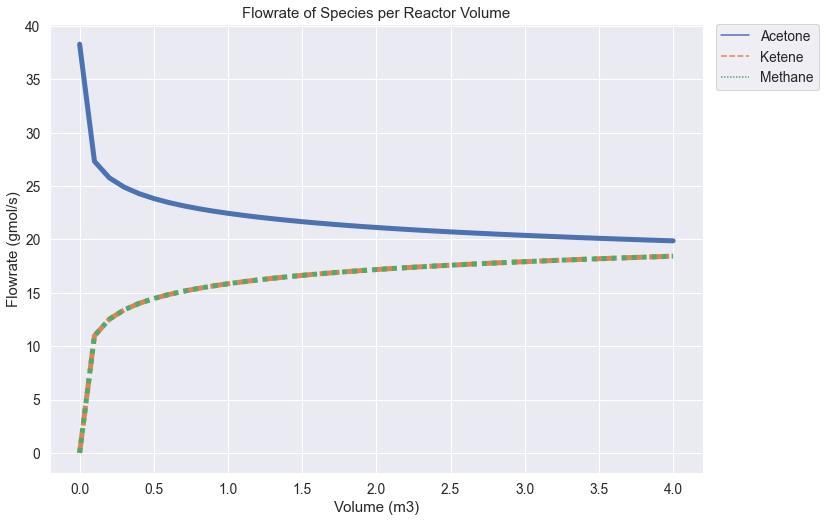

In [5]:
df_to_plot = pd.melt(frame = results.drop(['Temperature'], axis = 1),
                     id_vars = 'Volume',
                     var_name = 'Variable',
                     value_name = 'Value')

plt = sns.lineplot(data = df_to_plot, 
                      x = 'Volume', 
                      y = 'Value', 
                      style = 'Variable', 
                      hue = 'Variable',
                      lw = 5)
plt.set(xlabel = 'Volume (m3)',
        ylabel = 'Flowrate (gmol/s)',
        title = 'Flowrate of Species per Reactor Volume')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.plot()

[]

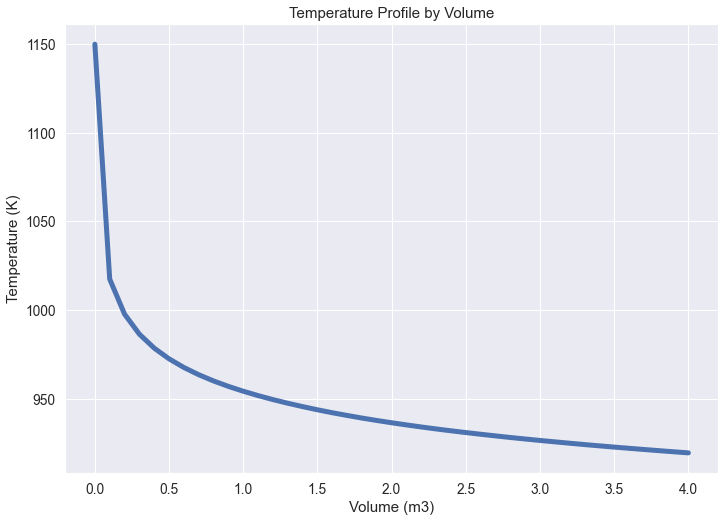

In [6]:
df_to_plot = pd.melt(frame = results,
                     id_vars = 'Volume',
                     var_name = 'Variable',
                     value_name = 'Value')

plt = sns.lineplot(data = results, x = 'Volume', y = 'Temperature', lw = 5)
plt.set(xlabel = 'Volume (m3)',
        ylabel = 'Temperature (K)',
        title = 'Temperature Profile by Volume')
plt.plot()

Looking at the molar flowrate and temperature plots, we can see that this reaction is very endothermic and the main problem happening is that the initial quick reduction in temperature significantly slows down the reaction meaning the vast majority of the reaction happens in the first $m^3$ of the reactor volume.

The code block below answers the last part of question 1 as to what the outlet molar flowrates of each component are.

In [7]:
Final_Acetone = round(results['Acetone'].values[-1], 2)
Final_Ketene = round(results['Ketene'].values[-1], 2)
Final_Methane = round(results['Methane'].values[-1], 2)

print('The Outlet Molar Flowrate of Acetone is:', Final_Acetone, 'gmol/s')
print('The Outlet Molar Flowrate of Ketene is:', Final_Ketene, 'gmol/s')
print('The Outlet Molar Flowrate of Methane is:', Final_Methane, 'gmol/s')

The Outlet Molar Flowrate of Acetone is: 19.87 gmol/s
The Outlet Molar Flowrate of Ketene is: 18.43 gmol/s
The Outlet Molar Flowrate of Methane is: 18.43 gmol/s


# Question 2

To increase the conversion of acetone, it is suggested to feed nitrogen along with acetone.  The total molar feed rate is maintained constant at 38.3 gmol/sec.  Calculate the final conversions and temperatures for the cases where 28.3, 18.3, 8.3, 3.3, and 0.0 gmol/sec nitrogen is fed into the reactor and plot the results as a function of reactor volume.

Based on the issues previously discussed, it is suggested to add Nitrogen to the inlet feed as a thermal mass to lessen the endothermic burden on the reaction. Though this may create some other issues (seperating out N2 before the final product and increases in flows to meet product demands), the primary concern is conversion which, this may help with.

For this problem, the inlet molar flowrate will stay the same meaning the initial concentration will stay the same, but the composition will change to be a mixture of nitrogen and acetone.  First, we need to make some modifications to our differential equations and inputs to be able to accept nitrogen, but since it is unreactive, the differential equation just equals 0.

In [8]:
def dV(v,variables):
    '''
    This function takes in a volume as an independent variable and
    a list called variables as the dependent variables and returns the
    incremental changes of the functions simulating the changing
    elements down the length of the reactor.
    '''
    # Define Variables for readability
    Face = variables[0] # gmol/s
    Fket = variables[1] # gmol/s
    Fmet = variables[2] # gmol/s
    T = variables[3] # K
    Fn2 = variables[4] # gmol/s

    # Define constants here
    P = 1.6 # atm
    T0 = 1150 # K
    R = 8.20573660809596 * 10**-5 # (m3 atm)/(K mol)

    # Create aggrgate variables
    Ft = (Face + Fket + Fmet + Fn2) #gmol/sec
    Ct0 = P/R/T0 # gmol/m3
    Cace = Ct0*(Face/Ft)*(T0/T) # gmol/m3

    # Define other variables
    k = math.exp(34.4 - (34222/T)) # 1/sec
    del_H = 80770 + 6.8*(T - 298) - 0.00575*(T**2 - 298**2) - (1.27*10**-6)*(T**3 - 298**3) # J/gmol
    Cpace = 26.2 + 0.183*T - (45.85*10**-6)*T**2 # J/(gmol K)
    Cpket = 20.04 + 0.0945*T - (30.95*10**-6)*T**2 # J/(gmol K)
    Cpmet = 13.39 + 0.077*T - (18.91*10**-6)*T**2 # J/(gmol K)
    Cpn2 = 6.25 + 0.00878*T - (2.1*10**-8)*T**2 # J/(gmol K)

    # Change Equations
    dFace = -k*Cace
    dFket = k*Cace
    dFmet = k*Cace
    dT = (dFace*del_H)/(Face*Cpace + Fket*Cpket + Fmet*Cpmet + Fn2*Cpn2)
    dFn2 = 0

    return [dFace, dFket, dFmet, dT, dFn2]

Next is to simulate all of the different flowrates of N2 suggested.  The cell below accomplishes this by using a for loop for the cases of interest.  The title of each graph as well as the N2 flow denotes what case it is.  Addtionally, the final conversions and temperatures and printed out as well.

The Final Conversion for 28.3 gmol/s N2 is  59.37 %
The Final Temperature for 28.3 gmol/s N2 is  924.79 K

The Final Conversion for 18.3 gmol/s N2 is  52.15 %
The Final Temperature for 18.3 gmol/s N2 is  919.54 K

The Final Conversion for 8.3 gmol/s N2 is  49.44 %
The Final Temperature for 8.3 gmol/s N2 is  918.96 K

The Final Conversion for 3.3 gmol/s N2 is  48.6 %
The Final Temperature for 3.3 gmol/s N2 is  919.13 K

The Final Conversion for 0.0 gmol/s N2 is  48.14 %
The Final Temperature for 0.0 gmol/s N2 is  919.33 K



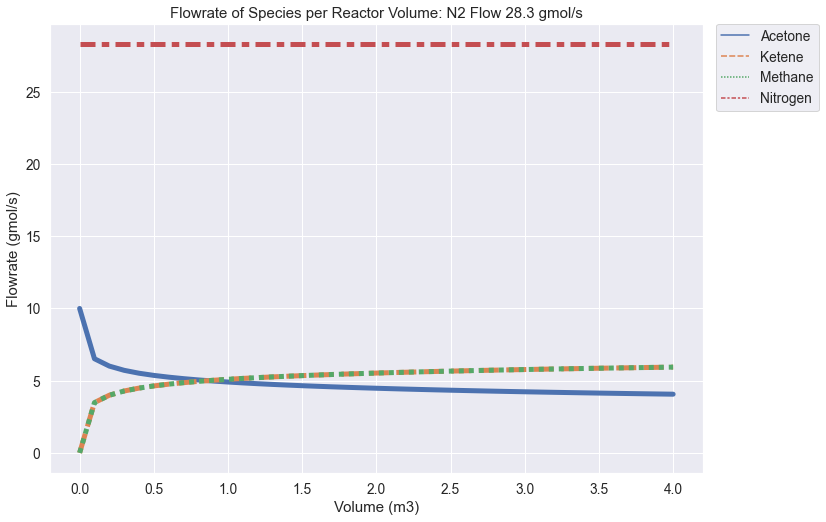

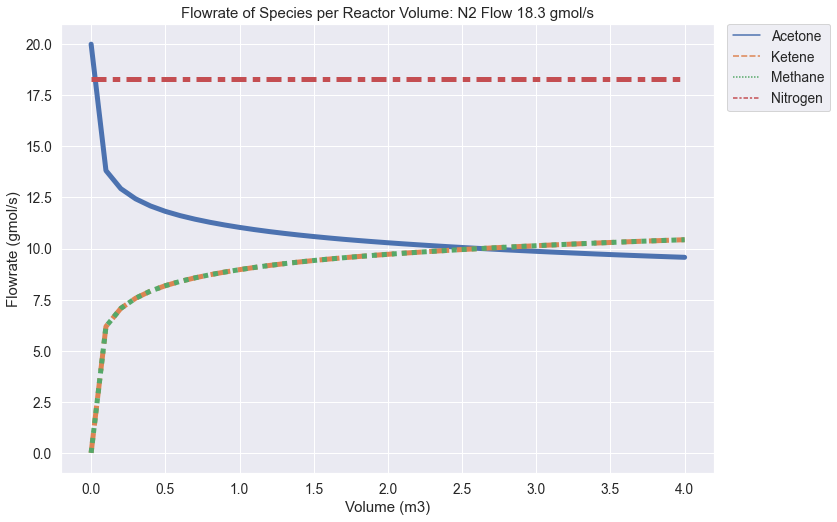

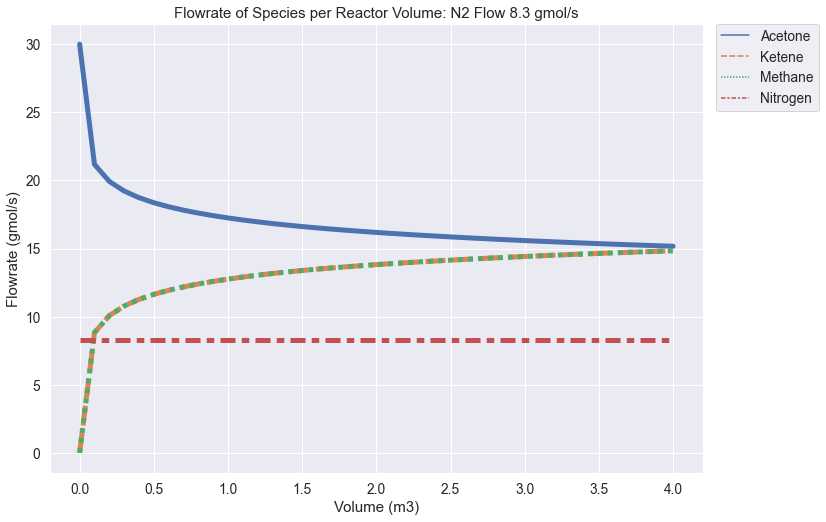

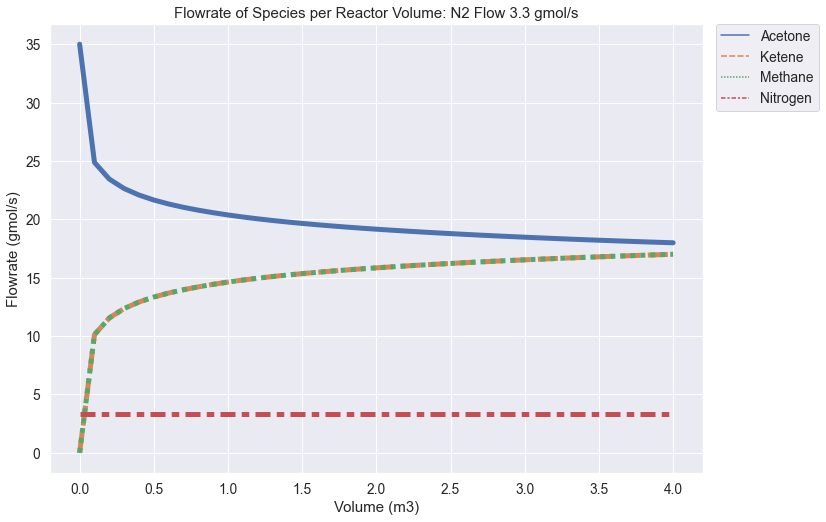

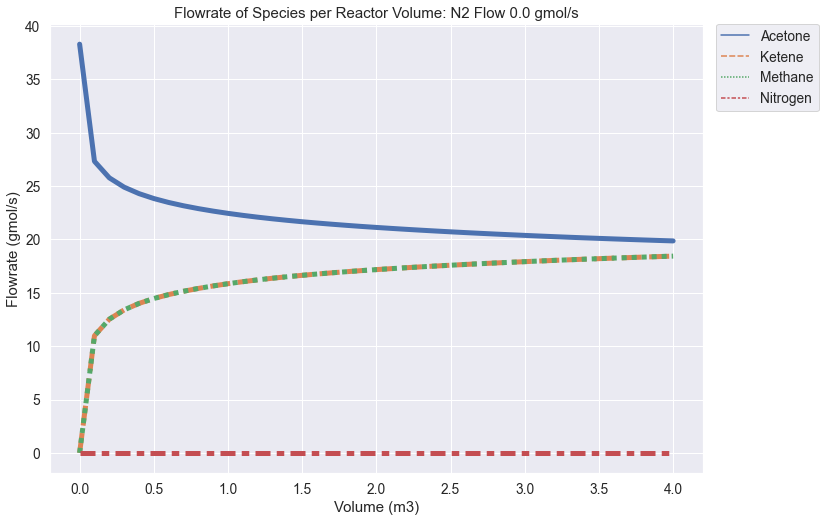

In [9]:
# min and max volume for integration
volume_span = [0, 4]
# specify each volume point I want data for
volume_series = np.arange(0,4+0.1,0.1)

# Flowrates of N2 to try
Simulating_N2 = [28.3, 18.3, 8.3, 3.3, 0.0] # gmol/sec
Simulating_Conversions = []
df_temperature = pd.DataFrame()
df_conversion = pd.DataFrame()

for N2 in Simulating_N2:
        # Model reactor with different inlet conditions
        solution = solve_ivp(dV, #function
                        volume_span, #min and max weight for integration
                        [38.3-N2, 0, 0, 1150, N2], # initial conditions (Acetone, Ketene, Methane, Temperature, N2)
                        t_eval = volume_series,
                        method='BDF') # BDF accounts for stiffnesses that may be present similar to ODE15s

        # Transform results from the reactor model
        results = pd.DataFrame(solution.y.transpose())
        results = pd.concat([pd.DataFrame(volume_series), results], axis=1)
        results.columns = ['Volume','Acetone','Ketene','Methane','Temperature', 'Nitrogen']

        # Plot the molar flowrates down the reactor
        df_to_plot = pd.melt(frame = results.drop(['Temperature'], axis = 1),
                        id_vars = 'Volume',
                        var_name = 'Variable',
                        value_name = 'Value')

        matplotlib.pyplot.figure()
        plt = sns.lineplot(data = df_to_plot, 
                        x = 'Volume', 
                        y = 'Value', 
                        style = 'Variable', 
                        hue = 'Variable',
                        lw = 5)
        plt.set(xlabel = 'Volume (m3)',
                ylabel = 'Flowrate (gmol/s)',
                title = 'Flowrate of Species per Reactor Volume: N2 Flow ' + str(N2) +' gmol/s')
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        plt.plot()

        # Print out the final temperature and conversion for each case
        Final_T = round(results['Temperature'].values[-1], 2)
        conversion = (results['Acetone'][0]-results['Acetone'].values[-1])/results['Acetone'][0]*100
        Simulating_Conversions.append(conversion)

        print('The Final Conversion for', N2, 'gmol/s N2 is ', round(conversion,2), '%')
        print('The Final Temperature for', N2, 'gmol/s N2 is ', Final_T, 'K')
        print()

        # Save the tempearture and conversions for visualizations later on
        df_temperature[str(N2)] = results['Temperature']
        df_conversion[str(N2)] = (results['Acetone'][0]-results['Acetone'])/results['Acetone'][0]*100

# Outside of the for loop at the end, I am adding the Volume measurements to the temperature and conversion plots
df_temperature['Volume'] = results['Volume']
df_conversion['Volume'] = results['Volume']

Below is the temperature plot for each case plotted against eachother.  Looking at the temperature profiles, they don't change much with the exception of the highest flowrate of nitrogen, mostly due to the low comparitive heat capacity.  However, looking at the actual numbers, there is some parabolic nature to the temperatures with a flow of 8.3 gmol/s of Nitrogen having the lowest final temperature.

[]

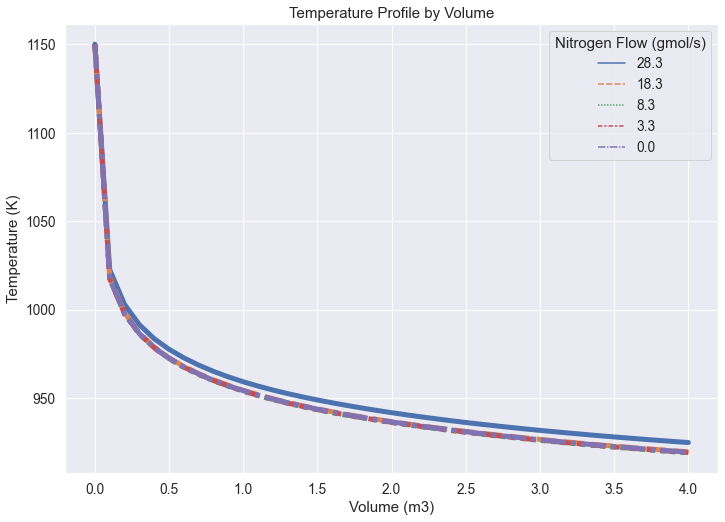

In [10]:
# Plotting Temperature
df_to_plot = pd.melt(frame = df_temperature,
                     id_vars = 'Volume',
                     var_name = 'Variable',
                     value_name = 'Value')

plt = sns.lineplot(data = df_to_plot, 
                   x = 'Volume', 
                   y = 'Value', 
                   hue = 'Variable',
                   style = 'Variable',
                   lw = 5)
plt.set(xlabel = 'Volume (m3)',
        ylabel = 'Temperature (K)',
        title = 'Temperature Profile by Volume')
plt.legend(title = 'Nitrogen Flow (gmol/s)')

plt.plot()

I'm uncertain if a plot of conversion for each case is also needed, but I did it still and the results are shown below.

[]

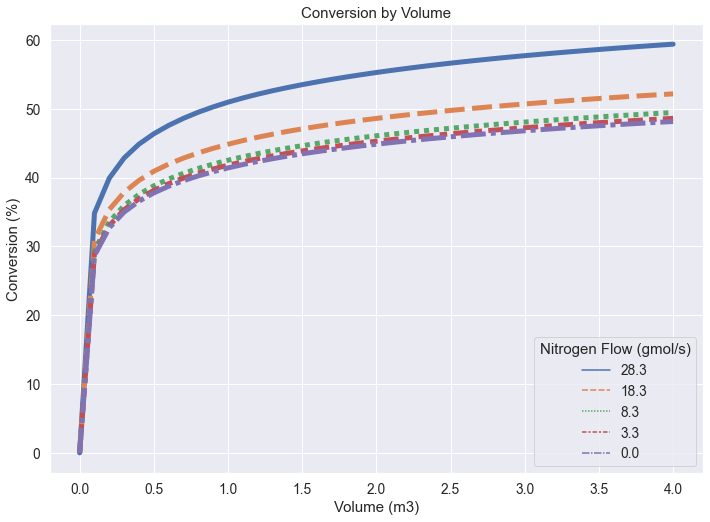

In [11]:
# Plotting Conversion down length of reactor
df_to_plot = pd.melt(frame = df_conversion,
                     id_vars = 'Volume',
                     var_name = 'Variable',
                     value_name = 'Value')

plt = sns.lineplot(data = df_to_plot, 
                   x = 'Volume', 
                   y = 'Value', 
                   hue = 'Variable',
                   style = 'Variable',
                   lw = 5)
plt.set(xlabel = 'Volume (m3)',
        ylabel = 'Conversion (%)',
        title = 'Conversion by Volume')
plt.legend(title = 'Nitrogen Flow (gmol/s)')

plt.plot()

From the print out, we can see that the increase in the amount of nitrogen does increase the conversion.  However, suggestions to make it better would be to use a compound with a higher heat capacity or just putting a jacket/heater on the reactor.  To show the conversion increasing with increasing N2 flowrate, an additional graph is shown below. Again, even though the conversion is increasing, this causes other issues that need to be addressed in the larger picture.

[]

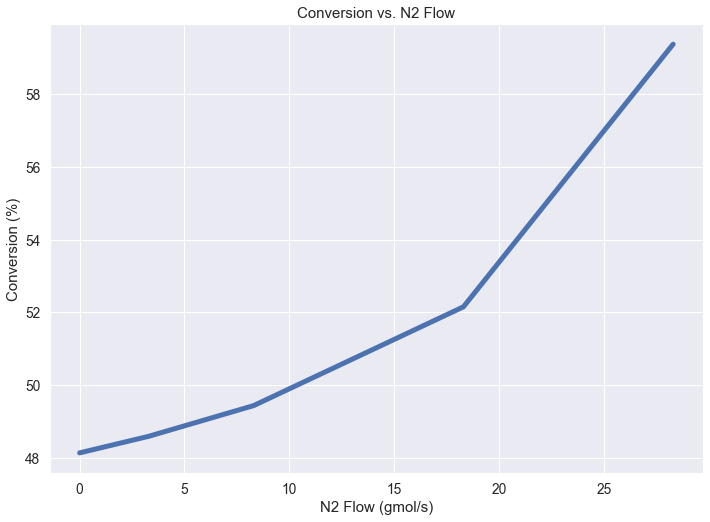

In [12]:
# Plotting Outlet Conversion vs N2 Flowrate
plt = sns.lineplot(x = Simulating_N2,
                   y = Simulating_Conversions,
                   lw = 5)
plt.set(xlabel = 'N2 Flow (gmol/s)',
                ylabel = 'Conversion (%)',
                title = 'Conversion vs. N2 Flow')
plt.plot()

# Question 3

How does the final conversion of acetone change if the reactor is operated in the conditions given for part 1 but the operating pressure is changed to 2 atm, 3 atm, 4 atm, and 5 atm?  Show the plot of final conversion as a function of operating pressure in the pressure range 1.6 atm to 5 atm.

This what-if analysis can also be completed using a for loop.  However, since the variable being changed is a constant in the reactor, the for loop will need to include function for the reactor as well.  With that being said, it is anticipated that the conversion will increase for this case becasue increasing the pressure increases the concentration of acetone as well.

In [13]:
Simulating_Pressures = [1.6, 2, 3, 4, 5] # atm
Simulating_Conversions = []

for Pressure in Simulating_Pressures:
    def dV(v,variables):
        '''
        This function takes in a volume as an independent variable and
        a list called variables as the dependent variables and returns the
        incremental changes of the functions simulating the changing
        elements down the length of the reactor.
        '''
        # Define Variables for readability
        Face = variables[0] # gmol/s
        Fket = variables[1] # gmol/s
        Fmet = variables[2] # gmol/s
        T = variables[3] # K

        # Define constants here
        P = Pressure # atm
        T0 = 1150 # K
        R = 8.20573660809596 * 10**-5 # (m3 atm)/(K mol)

        # Create aggrgate variables
        Ft = (Face + Fket + Fmet) #gmol/sec
        Ct0 = P/R/T0 # gmol/m3
        Cace = Ct0*(Face/Ft)*(T0/T) # gmol/m3

        # Define other variables
        k = math.exp(34.4 - (34222/T)) # 1/sec
        del_H = 80770 + 6.8*(T - 298) - 0.00575*(T**2 - 298**2) - (1.27*10**-6)*(T**3 - 298**3) # J/gmol
        Cpace = 26.2 + 0.183*T - (45.85*10**-6)*T**2 # J/(gmol K)
        Cpket = 20.04 + 0.0945*T - (30.95*10**-6)*T**2 # J/(gmol K)
        Cpmet = 13.39 + 0.077*T - (18.91*10**-6)*T**2 # J/(gmol K)

        # Change Equations
        dFace = -k*Cace
        dFket = k*Cace
        dFmet = k*Cace
        dT = (dFace*del_H)/(Face*Cpace + Fket*Cpket + Fmet*Cpmet)

        return [dFace, dFket, dFmet, dT]

    # min and max volume for integration
    volume_span = [0, 4]
    # specify each volume point I want data for
    volume_series = np.arange(0,4+0.1,0.1)

    solution = solve_ivp(dV, #function
                        volume_span, #min and max weight for integration
                        [38.3, 0, 0, 1150], # initial conditions (Acetone, Ketene, Methane, Temperature)
                        t_eval = volume_series,
                        method='BDF') # BDF accounts for stiffnesses that may be present similar to ODE15s

    results = pd.DataFrame(solution.y.transpose())
    results = pd.concat([pd.DataFrame(volume_series), results], axis=1)
    results.columns = ['Volume','Acetone','Ketene','Methane','Temperature']

    conversion = (results['Acetone'][0]-results['Acetone'].values[-1])/results['Acetone'][0]*100

    Simulating_Conversions.append(conversion)

[]

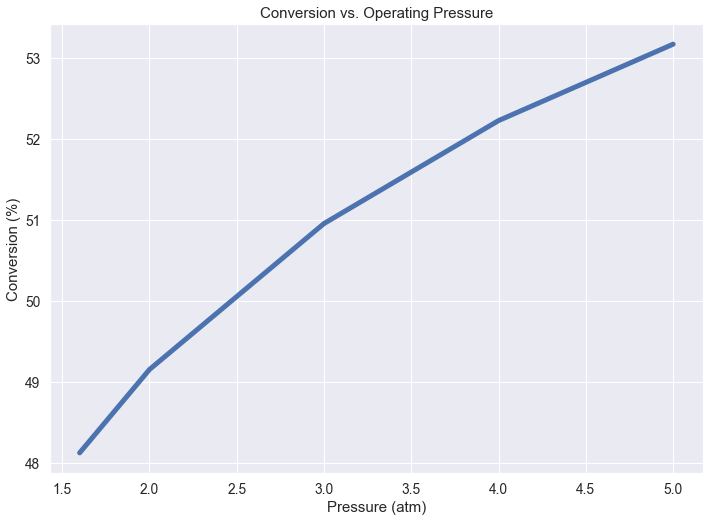

In [14]:
# Plot Conversion vs Pressure
plt = sns.lineplot(x = Simulating_Pressures,
                   y = Simulating_Conversions,
                   lw = 5)
plt.set(xlabel = 'Pressure (atm)',
                ylabel = 'Conversion (%)',
                title = 'Conversion vs. Operating Pressure')
plt.plot()

This plot shows that the conversion does increase with increasing pressure. This, however, would be an economic optimization with the additional compression/pump costs and does not address the endothermic nature of the reaction, the largest draw back from the current setup.